# Overview: Climate Analysis in Preparation for Vacation in Honolulu, Hawaii
DIRECTION AND GUIDANCE from the README file in the Resources Folder:
Use Python and SQLAlchemy to do basic climate analysis and data exploration of the provided climate database. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.  Convey your analysis to the user by creating a Hawaii Climate App designed using a Flask API.  The following nine step paradigm will be used as a pathway to outline the steps taken in this data problem solving effort.

##  The ASK:
The target App user is  making a decision on when to vacation in Honolulu, Hawaii.  This decision will be informed by precipitation and temperature analysis.  The API will provide general summary statistics on the daily weather (precipitation and temperature). The user will be asked for a vacation start and end date (ranging between 3 and 15 days) and the App will return summary statistics (for precipitation and temperature) for the selected dates.

## Data Sources:
### The Resources Folder includes the hawaii.sqlite database which provides historical weather data
### BACKGROUND (Discovery from Online Literature Review) - Conclusion: "... there is no ‘bad’ time to visit."
The following source(s) were visited to gain an overall appreciation for Hawaii's weather and that might impact a decision to vacation in Hawaii.

https://www.travelonline.com/hawaii/best-time-to-visit Overall best time to visit Hawaii:
Hawaii's dry season falls from April to October while the wet season occurs from November to March. Although summer sounds like the best time to travel to Hawaii, the climate is actually very hot and humid, something to keep in mind if you struggle with extreme temperatures. Fortunately, Hawaii is incredibly pleasant throughout the year so there is no ‘bad’ time to visit. Temperature-wise, April, May, September and October are probably the most enjoyable times to visit (which luckily coincides with some good travel deals).

Other consideration: The best time to travel to Hawaii also depends on which islands you'll be spending time on, as each is different to the next. If you want to catch Hawaii's world famous surf then the best time to visit is from November to January; however if this isn't your cup of tea than you may want to avoid the crowds and traffic that flock to the Oahu North Shore around this time. Towards late summer when the weather has cooled down a little and the surf crowds have passed, the whole family can enjoy calmer conditions.

https://www.gohawaii.com/trip-planning/weather for a Temperature and Precipitation Summary:
 * Temperature: Weather in The Hawaiian Islands is very consistent, with only minor changes in temperature throughout the year. There are really only two seasons in Hawaii: summer (kau) from May to October and winter (hooilo) from November to April. The average daytime summer temperature at sea level is 85° F (29.4° C), while the average daytime winter temperature is 78° (25.6° C). Temperatures at night are approximately 10° F lower than the daytime.

 * Precipitation: The wettest months are from November to March, but winter rains do not generally disrupt vacation plans, since the weather is very localized. This means that if it is raining where you are, there is almost always a sunny spot to be found around the coast.
According to http://www.rssweather.com/climate/Hawaii/Honolulu/ Honolulu's coldest month is February when the average temperature overnight is 65.4°F. In August, the warmest month, the average day time temperature rises to 88.9°F.
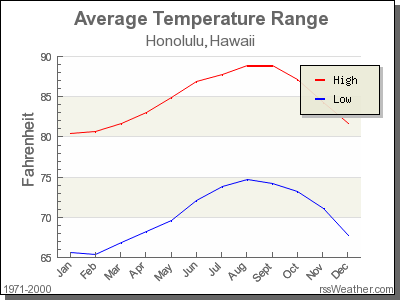

The driest month in Honolulu is June with 0.43 inches of precipitation, and with 2.85 inches December is the wettest month.
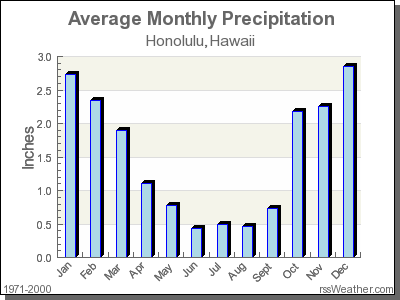

## Data Strategy and Metrics
Temperature: Since the highs in Hawaii are mild compared to summer highs for most cities the Continental US (CONUS), higher temperatures will be considered better.  For Precipitation, lower is considered better with zero being the best

## Data Retrieval Plan
Data was provided by the "customer"

## Retrieve the Data
The weather data tables (provided in the hawaii.sqlite database) were Reflected into SQLAlchemy ORM

## Assemble and Clean (Exploratory Data Analysis)
The Direction and Guidance requested specific steps be taken.  Specific questions are expected to be answered as part of this step of the process and are addressed below.

## Analyze for Trends (Exploratory Data Analysis)
The Direction and Guidance requested specific steps be taken.  Specific questions are expected to be answered as part of this step of the process and are addressed below.

## Acknowledge Limitations
This analysis assumes the weather for Aug 2016 to AUG 2017 is representative for future year weather

## Make the Call / Tell the Story

In [3]:
# Dependencies
import numpy as np
import pandas as pd
import pandas_profiling # an exploritory data analysis package in pandas

import datetime as dt

%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import plotly.plotly as py
import plotly.graph_objs as go

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Retrieve the Data - Reflect Tables into SQLAlchemy ORM

## Data Sources: The hawaii.sqlite database:
The hawaii.sqlite database contains two tables: measurement and station. The measurement table contains five columns:  id, station , date, tobs and prcp. The station table contains six columns: id, name, latitude, longitude, elevation.  Using SQLAlchemy connect to the hawaii.sqlite database.  Use automap_base to reflect the classes (tables) in the database.  Create a session (link) from Python to the database.

In [4]:
# Define the Path to the hawaii.sqlite database located in the Resources folder
database_path = "Resources/hawaii.sqlite"

In [5]:
# Create an engine that can talk to the hawaii.sqlite database (using the database_path created above)
engine = create_engine(f"sqlite:///{database_path}")

In [6]:
# Declare a Base using `automap_base()`which automatically 
# generates mapped classes and relationships from a database schema (typically the one which is reflected).
Base = automap_base()

# reflect hawaii.sqlite database into a new model and reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# Print all of the classes (in this case tables) that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to both the Measurement and Station tables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create a session (link) from Python to the sqlite database
session = Session(engine)

In [10]:
# For the Measurement table - Display the row's and columns and data in dictionary format
first_row_Measurement = session.query(Measurement).first()
first_row_Measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x23716147320>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
# For the Station table - Display the row's and columns and data in dictionary format
first_row_Station = session.query(Station).first()
first_row_Station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2371effa6a0>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Data Analysis

## Precipitation Analysis Using the Measurement Table

In [12]:
# Perform some inital analysis of dates in the Measurement table
# What is the last date?
last_date_measurement = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_measurement = last_date_measurement[0]
last_date_measurement

'2017-08-23'

In [13]:
# Calculate the date 1 year ago from the last data point in the database (the last date - 365 days)
# Note currently last_date_measurement is a string ('2017-08-23', use dt.datetime.strptime to convert to date and calculate query date
# Use dt.timedelta to subtract one year (365 days) from last day in Measurement table
one_year_ago = dt.datetime.strptime(last_date_measurement, '%Y-%m-%d') - dt.timedelta(days=365)

print("Query Date:", one_year_ago)

Query Date: 2016-08-23 00:00:00


In [14]:
# Design a query to retrieve precipitation data for the last 12 months of precipatation data
last_year_precipation_query = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).all()

In [15]:
# Save the query results as a Pandas DataFrame
last_year_precipitation_df = pd.DataFrame(last_year_precipation_query, columns=['date', 'station','precipitation'])

# Convert the 'date' column from string to a date using pandas to_datetime
last_year_precipitation_df['date'] = pd.to_datetime(last_year_precipitation_df['date'], format='%Y-%m-%d')

# Set the index to the date column using pandas set_index
last_year_precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date using pandas sort_values, note ascending is the default so it can be left off
last_year_precipitation_df = last_year_precipitation_df.sort_values(by=['date'], ascending=True)

last_year_precipitation_df = last_year_precipitation_df.groupby(['date', 'station']).mean() # since each station has at most one measurement per day the mean (of one) is just the measurement
last_year_precipitation_df.head(10)

precipitation
date       station                   
2016-08-24 USC00513117           2.15
           USC00514830           2.28
           USC00516128           1.45
           USC00517948            NaN
           USC00519281           2.15
           USC00519397           0.08
           USC00519523           1.22
2016-08-25 USC00513117           0.08
           USC00514830           0.00
           USC00516128           0.11

<IPython.core.display.Javascript object>


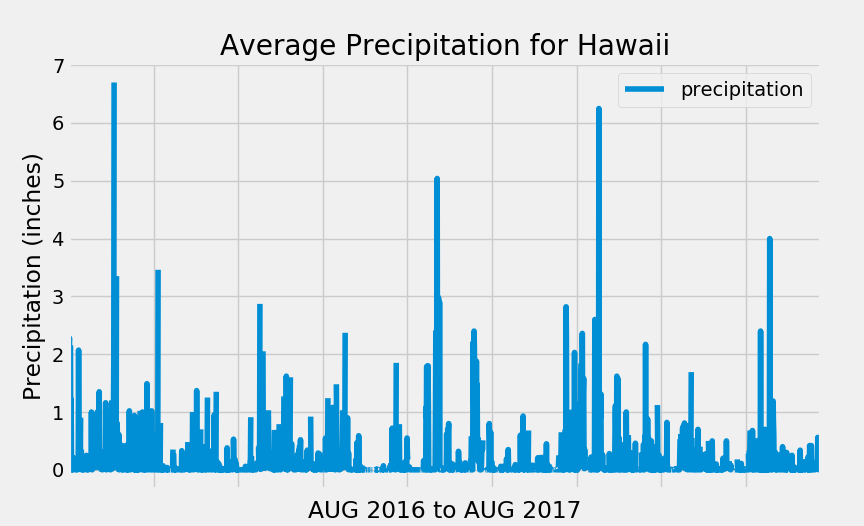

In [17]:
# Plot the Results in a Matplotlib bar chart and default to the style.use('fivethirtyeight')
ax = last_year_precipitation_df.plot()

# Set plot properties
ax.xaxis.set_major_formatter(plt.NullFormatter()) # removes the dates from the x axis
plt.title("Average Precipitation for Hawaii")
plt.ylabel("Precipitation (inches)")
plt.xlabel("AUG 2016 to AUG 2017") 

# Save plot
plt.savefig("Output/Average Precipitation by Date.png", index=False, header=True)

In [18]:
# Use Pandas describe to calcualte the summary statistics for the last_year_precipitation_df
last_year_precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Option to describe in performing inital Exploritory Data Analysis is using Pandas Profiling package
# Note this requires an install using conda install -c anaconda pandas-profiling or pip install pandas-profiling

# pandas_profiling.ProfileReport(last_year_precipitation_df)

## Temperature Analysis Using the Measurement Table

In [20]:
# Design a query to show how many stations are available in this dataset?
station_query = session.query(Measurement.station).distinct().count()
print(f'There are {station_query} stations available')

There are 9 stations available


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count_query = session.query(Measurement.id, Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

station_count_query_df = pd.DataFrame(station_count_query, columns=['station id', 'station','observations'])
print(f'Stations in order of activity')
station_count_query_df

Stations in order of activity


,station id,station,observations
0,12188,USC00519281,2772
1,1,USC00519397,2724
2,2725,USC00513117,2709
3,9519,USC00519523,2669
4,16939,USC00516128,2612
5,5434,USC00514830,2202
6,14960,USC00511918,1979
7,7636,USC00517948,1372
8,9008,USC00518838,511


In [22]:
# Station USC00519281 - id 12188 was the most "active" with 2772 rows
most_active_station_id = station_count_query[0][0]
most_active_station = station_count_query[0][1]
print(f'The most active station is {most_active_station}, with station id {most_active_station_id }')

The most active station is USC00519281, with station id 12188


In [23]:
# calculate the lowest temperature recorded for station USC00519281 station id 12188, 

station_USC00519281_min = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

print(f'Station USC00519281 minimum recorded temperature was {station_USC00519281_min}')

Station USC00519281 minimum recorded temperature was [(54.0,)]


In [24]:
# calculate the highest temperature recorded for station USC00519281 
station_USC00519281_max = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

print(f'Station USC00519281 maximum recorded temperature was {station_USC00519281_max}')

Station USC00519281 maximum recorded temperature was [(85.0,)]


In [25]:
# Calculate the avergae temperatur recorded for station USC00519281 
station_USC00519281_avg = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
print(f'Station USC00519281 average recorded temperature was {station_USC00519281_avg}')

Station USC00519281 average recorded temperature was [(71.66378066378067,)]


In [26]:
# Choose the station with the highest number of temperature observations.
most_temperature_obs = session.query(Measurement.station, Measurement.id, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()

station_most_temp_obs = most_temperature_obs[0]
print(f'Station {station_most_temp_obs} has the most temperature observations')

Station USC00519281 has the most temperature observations


In [27]:
# Query the last 12 months of temperature observation data for this station 
Temperature_obs = session .query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == station_most_temp_obs).all()

Temperature_obs_df = pd.DataFrame(Temperature_obs, columns=['temperature'])
Temperature_obs_df.head()

,temperature
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


<IPython.core.display.Javascript object>


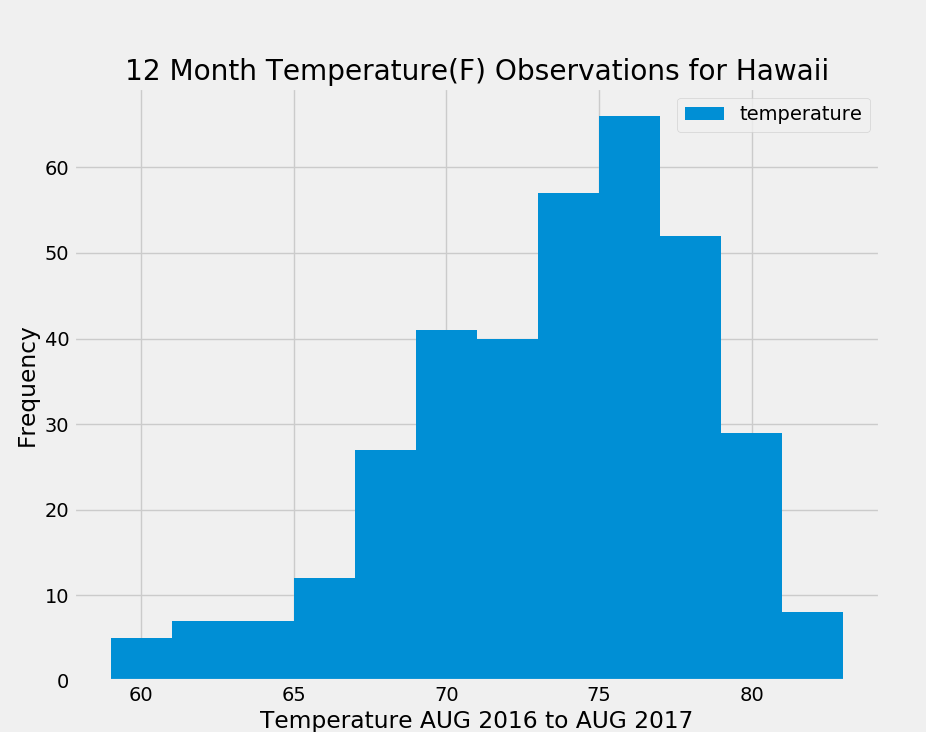

In [93]:
# Plot the results as a histogram with 12 bins
Temperature_obs_df.plot.hist(bins = 12, title = "12 Month Temperature(F) Observations for Hawaii")

# Set plot properties
plt.xlabel("Temperature AUG 2016 to AUG 2017") 
plt.savefig('Output/Temp_Obs.png')

In [94]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
vacation_calc_temps = calc_temps("2016-02-28", "2016-03-05")
print(f'The estimated min, avg and max temperatures for 28 FEB to 05 MAR are: {vacation_calc_temps}')

# Note this function does not account for leap years

The estimated min, avg and max temperatures for 28 FEB to 05 MAR are: [(62.0, 69.88636363636364, 80.0)]


In [96]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

vacation_temps = calc_temps('2016-02-28', '2016-03-05')
print('Using weather data from AUG 2016 to AUG 2017,')
print(f'The estimated min, avg, and max temperatures for 28 FEB to 05 MAR are: {vacation_temps}')

Using weather data from AUG 2016 to AUG 2017,
The estimated min, avg, and max temperatures for 28 FEB to 05 MAR are: [(62.0, 69.88636363636364, 80.0)]


In [97]:
# Create a DataFrame with t_min, t_avg, t_max values from vacation_temps
vacation_temps_df = pd.DataFrame(vacation_temps, columns=['min_temp', 'avg_temp', 'max_temp'])
vacation_temps_df

,min_temp,avg_temp,max_temp
0,62.0,69.886364,80.0


<IPython.core.display.Javascript object>


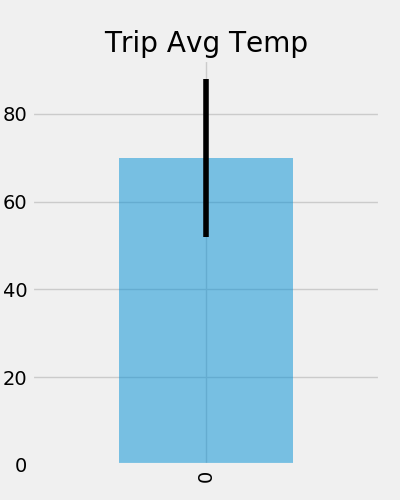

In [118]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
vacation_temps_df.plot.bar(y='avg_temp', yerr = (vacation_temps_df['max_temp'] - vacation_temps_df['min_temp']),\
                                title='Trip Avg Temp', alpha=.5, figsize=(4,5), legend=None)
# Set plot properties
plt.ylabel('Temperature (F)')
plt.savefig('Output/Trip Avg Temp.png')


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# This will require columns from both the Measurement and Station tables

In [33]:
# For the Measurement table - Display the row's and columns and data in dictionary format
first_row_Measurement = session.query(Measurement).first()
first_row_Measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x23716147320>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [34]:
# For the Station table - Display the row's and columns and data in dictionary format
first_row_Station = session.query(Station).first()
first_row_Station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2371effa6a0>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US'}

In [98]:
# Calculate the total amount of rainfall per weather station for your trip dates (i.e. 28 FEB to 05 MAR) using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# This JOINs the data in the two tables together into a single dataset (in the form of a tuple)

def calc_prcp (start_date, end_date):
    """Precipitation information per weather station.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in decending order.
    """
    
    sel = [Measurement.station,
             Station.name,
             Station.latitude,
             Station.longitude,
             Station.elevation,
             Measurement.prcp]
      
    return session.query(*sel).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).\
            group_by(Measurement.station).\
            order_by(Measurement.prcp.desc()).all()

calc_prcp_df = pd.DataFrame(calc_prcp('2016-02-28', '2016-03-05'), columns=['station_id','station name', 'latitude', 'longitude', 'elevation', 'precipitation'])
calc_prcp_df



,station_id,station name,latitude,longitude,elevation,precipitation
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.0
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.0
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.0
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.0
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.0
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [40]:
# Create a query that will calculate the daily normals (adapt the example defined function "daily_normals" below
# to accept a start and end date for a vacation)
# Find temp_min, temp_max, and temp_avg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# Show results of daily_normals for 01 JAN (i.e. month-day "01-01") using all years in the hawaii.sqlite db
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [100]:
# calculate the daily normals (for temperature) for your trip
# push each tuple of calculations into a list called `vacation_daily_normals_temp`

# Note this should account for data recorded for the last leap year which was 2016

# Set the start and end date of the trip
vacation_day_1 = '2016-02-28'
vacation_last_day = '2016-03-05'

# Use the start and end date to create a range of dates
vacation_dates = session.query(Measurement.date).\
    filter(Measurement.date >= vacation_day_1).\
    filter(Measurement.date <= vacation_last_day).\
    group_by(Measurement.date).all()
vacation_dates = [x[0] for x in vacation_dates]
vacation_dates

['2016-02-28',
 '2016-02-29',
 '2016-03-01',
 '2016-03-02',
 '2016-03-03',
 '2016-03-04',
 '2016-03-05']

In [101]:
# Stip off the year by stripping off the first five characters of the string (i.e. '2017-') this will leave month-day
# in %m-%d format
# save a list of %m-%d strings as vaction_dates_strip

vacation_dates_strip = [x[5:] for x in vacation_dates] 
vacation_dates_strip

['02-28', '02-29', '03-01', '03-02', '03-03', '03-04', '03-05']

In [104]:
# Loop through the list of %m-%d strings and calculate the normals for each date
# Use SQLAlchemy func and strftime %m for month as a zero-padded decimal number and %d for day of the month as a zero-padded decimal number.
# this takes the truncated timestamps string from the Measurement.dates between vacation_start_month_day and vacation_end_month_day
vacation_start_month_day = vacation_dates_strip[0] # first entry 
vacation_end_month_day = vacation_dates_strip[-1] # last entry


def vacation_daily_normals_temp(vacation_start_month_day, vacation_end_month_day):
    """vacation daily normals temperature.
    
    Args:
        vacation_start_month_day (str): A date string in the format '%m-%d'
        vacation_end_month_day (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals for temperature, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    
    return session.query(*sel).filter(func.strftime('%m-%d', Measurement.date) >= vacation_start_month_day).\
                                       filter(func.strftime('%m-%d', Measurement.date) <= vacation_end_month_day).\
                                       group_by(func.strftime('%m-%d', Measurement.date)).all()

# Show results of vacation_daily_normals_temp for vacation_day_1 = '2017-02-28' and vacation_last_day = '2017-03-05') using all years in the hawaii.sqlite db
print(f'Estimated Vacation Daily Normals Temperature for vacation start 28 FEB and end on 05 MAR')
print(f'This includes a Daily Normal from data for 2016 which was the last leap year and includes a 29 FEB)
print(f'temp_min, temp_avg, temp_max')
vacation_daily_normals_temp("02-28", "03-05")

Estimated Vacation Daily Normals Temperature for vacation start 28 FEB and end on 05 MAR
This includes a Daily Normal from data for 2016 which was the last leap year and includes 29 FEB
temp_min, temp_avg, temp_max


[(65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [114]:
# Load the previous query results into a Pandas DataFrame 
vacation_daily_normals_temp_df = pd.DataFrame(vacation_daily_normals_temp("02-28", "03-05"), columns=['temp_min', 'temp_avg', 'temp_max'])

# Add the `trip_dates` range as the `date` index
vacation_daily_normals_temp_df['date'] = vacation_dates

# Convert the 'date' from a string to a date using pandas to_datetime
vacation_daily_normals_temp_df['date'] = pd.to_datetime(vacation_daily_normals_temp_df['date'], format='%Y-%m-%d')

# Reindex on the date column
# Set the index to the date column using pandas set_index
vacation_daily_normals_temp_df.set_index('date', inplace=True)

vacation_daily_normals_temp_df

,temp_min,temp_avg,temp_max
date,,,
2016-02-28,65.0,70.655172,80.0
2016-02-29,67.0,71.733333,79.0
2016-03-01,64.0,70.032787,76.0
2016-03-02,61.0,70.366667,78.0
2016-03-03,60.0,70.068966,78.0
2016-03-04,57.0,69.272727,77.0
2016-03-05,60.0,67.890909,76.0


<IPython.core.display.Javascript object>


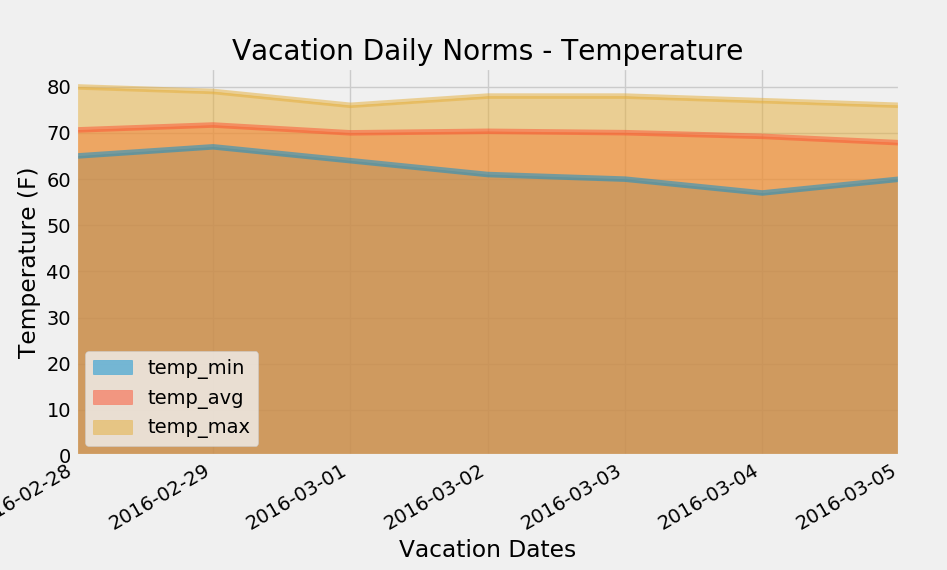

In [120]:
# Plot the daily normals as an area plot with `stacked=False` and x_compat to handel the dates
vacation_daily_normals_temp_df.plot(kind='area', alpha=.5, stacked=False, x_compat=True, title='Vacation Daily Norms - Temperature')

# Set plot properties
plt.ylabel('Temperature (F)')
plt.xlabel('Vacation Dates')
plt.savefig('Output/Vacation_Daily_Normals_Temp.png')